<a href="https://colab.research.google.com/github/urieliram/tc_uc/blob/main/ExtraxtLogCPLEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import files
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,ytitle_,xtitle_,namefile_):
    fig, ax1 = plt.subplots(figsize=(6,4))
    plt.title(title_,fontsize='large',color=LETRASNARA)
    ax1.set_xlabel(xtitle_, color=LETRASNARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)    
    plt.plot(serie_)
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [73]:
class Extract:

  def findPos(self,file,spected, starter = "Node  Left"):
    file = open(file,"r")
    for i,j in enumerate(file):
      if starter in j:
        return [(j.index(k)+len(k)-1) for k in spected]
  
  def getFilelog(self,f):
    with open(f, 'r') as file:
      data = file.read().replace('\n', '')
    tmp = []
    for i in re.findall(r"\w*Logfile\s*\'*[a-zA-z.+]*\'",data):
      tmp.append(i.replace("'","").split(" ")[1])
    return tmp

  def createTables(self,fn):
    table_start = False
    spected = ['Node', 'Left', 'Objective', 'IInf', 'Integer', 'Bound', 'ItCnt', 'Gap']
    expectedPositions = self.findPos(fn,spected)
    tables = {"seconds":[],"ticks":[],"solution":[],"Node":[],"Left":[],"Objective":[],"IInf":[],"Integer":[],"Bound":[],"ItCnt":[],"Gap":[],"cuts":[]}
    time = None
    ticks = None
    cuts = None
    f = open(fn,"r")    
    for i in f:
      if("Cover cuts applied" in i or "Performing restart 1" in i):
        table_start = False
      if("Elapsed time" in i):
          tmp = [float(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          time = tmp[0]
          ticks = tmp[1]
      if(table_start):        
        if((str(i)[0] == " " or str(i)[0] == "*") and str(i)[expectedPositions[0]].isdigit()):
          i = i.replace("uts: "," uts:")
          tables["seconds"].append(time)
          tables["ticks"].append(ticks)
          tables["solution"].append(1 if i[0]=="*" else 0)
          tables["cuts"].append(None)
          for j,m in zip(expectedPositions,spected):
            if i[j] is not " ":
              tmp = ""
              for k in range(j,0,-1):
                if i[k] is not " ":
                  tmp += i[k]
                else: 
                  break 
              tmp = tmp[::-1]
              if("ut" in tmp.lower() or "infeasible" in tmp.lower() or "integral" in tmp.lower()):
                if("uts" in tmp.lower()):
                  tables["cuts"][-1] = int(tmp.split(":")[1])
                tables[m].append(tables[m][-1])
              else:
                if m == "Gap":
                  tables[m].append(float(tmp)/100)
                else: 
                  tables[m].append(float(tmp))
            else:
              tables[m].append(None)
      if("Node  Left"):
        table_start = True

    return tables

  def extract(self,fn):
    variables = {"mipPresolveEliminated":[],"mipPresolveModified":[],"aggregatorDid":[],"reducedMipHasColumns":[],"reducedMipHasNonZero":[],"reducedMipHasBinaries":[],"reducedMipHasGeneral":[],"cliqueTableMembers":[],"rootRelaxSolSeconds":[],"rootRelaxSolTicks":[]}
    variables["logFile"] = self.getFilelog(fn)
    tables = self.createTables(fn)
    f = open(fn, "r")    
    for i in f:
      if("linear optimization" in i):
        variables["linearOpt"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("optimality gap tolerance" in i):
        variables["gapTol"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("time limit in seconds" in i):
        variables["timeLimit"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("emphasis for MIP optimization" in i):
        variables["mipOpt"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("Objective sense" in i):
        variables["objSense"] = i.replace(" ","").replace("\n","").split(":")[1]
      if("Variables" in i):
        if("Box:" in i):
          variablesValue = ["variablesValue","Nneg","Box","Binary"]
          for j,k in enumerate(re.findall(r'\d+', i.replace(" ","").replace("\n","").split(":",1)[1])):
            variables[variablesValue[j]] = float(k)
        else:
          variablesValue = ["minLB","maxUb"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
      if("Objective nonzeros" in i):
        if("Min" in i or "Max" in i):
          variablesValue = ["objNonZerosMin","objNonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["objNonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("Linear constraints" in i):
        if("Less" in i):
          variablesValue = ["linearConstraintsValue","less","greater","equal"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          pass
      if("Nonzeros" in i):
        if("Min" in i):
          variablesValue = ["nonZerosMin","nonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["nonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("RHS nonzeros" in i):
        if("Min" in i):
          variablesValue = ["rhsNonZerosMin","rhsNonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["rhsNonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("CPXPARAM_TimeLimit" in i):
        variables["CPXPARAM_TimeLimit"] = float(i.replace("\n","").split(" ")[-1])
      if("MIP Presolve eliminated" in i):
        variables["mipPresolveEliminated"].append([int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)])
      if("MIP Presolve modified " in i):
        variables["mipPresolveModified"].append(int(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)[0]))
      if("Reduced MIP has" in i):
        if("indicators." in i):
          tmp = [int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          variables["reducedMipHasBinaries"].append(tmp[0])
          variables["reducedMipHasGeneral"].append(tmp[1])
        else:
          tmp = [int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          variables["reducedMipHasColumns"].append(tmp[1])
          variables["reducedMipHasNonZero"].append(tmp[-1])
          reduceHasGeneral = []
      if("Clique" in i):
        variables["cliqueTableMembers"].append(float(i.replace(" ","").replace("\n","").split(":")[1]))
      if("Aggregator did" in i):
        variables["aggregatorDid"].append(int(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)[0]))
      if("Root relaxation" in i):
        tmp = [float(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
        variables["rootRelaxSolSeconds"].append(tmp[0])
        variables["rootRelaxSolTicks"].append(tmp[1])
      if("Lift and" in i):
        variables["liftAndProjectCuts"] = int(i.replace(" ","").replace("\n","").split(":")[1])
      if("Gomory fractional" in i):
        variables["gomoryFract"] = int(i.replace(" ","").replace("\n","").split(":")[1])

    df=pd.DataFrame.from_dict(tables).rename(columns={"seconds":"seconds","ticks":"ticks","solution":"solution","Node":"node","Left":"nodesLeft","Objective":"objective","IInf":"iinf","Integer":"bestInteger","Bound":"cutsBestBound","ItCnt":"itCnt","Gap":"gap","cuts":"cuts"})
    df['seconds'] = df['seconds'].fillna(0)
    eps=np.arange(0, 1, 1/(len(df)), dtype=float)
    df['eps'] = eps
    sum_column = df["seconds"] + df["eps"]
    df["seconds"] = sum_column
    df['ticks'] = df['ticks'].fillna(0)
    eps=np.arange(0, 1, 1/(len(df)), dtype=float)
    df['eps'] = eps
    sum_column = df["ticks"] + df["eps"]
    df["ticks"] = sum_column
    return df,variables

In [74]:
e = Extract()
df,dic =e.extract("/content/logfileMilparch.log")

In [75]:
df

,seconds,ticks,solution,node,nodesLeft,objective,iinf,bestInteger,cutsBestBound,itCnt,gap,cuts,eps
0,0.000000,0.000000,0,0.0,0.0,279312000.0,95.0,285486000.0,279312000.0,5900.0,NaN,NaN,0.000000
1,0.017544,0.017544,0,0.0,0.0,280818000.0,181.0,285486000.0,279312000.0,6770.0,NaN,215.0,0.017544
2,0.035088,0.035088,0,0.0,0.0,281139000.0,175.0,285486000.0,279312000.0,7103.0,NaN,181.0,0.035088
3,0.052632,0.052632,0,0.0,0.0,281235000.0,219.0,285486000.0,279312000.0,7549.0,NaN,125.0,0.052632
4,0.070175,0.070175,0,0.0,0.0,281376000.0,194.0,285486000.0,279312000.0,7834.0,NaN,140.0,0.070175
5,0.087719,0.087719,1,0.0,0.0,NaN,NaN,285486000.0,281376000.0,8164.0,0.0144,NaN,0.087719
6,0.105263,0.105263,0,0.0,0.0,281483000.0,323.0,285486000.0,281376000.0,8164.0,0.0140,144.0,0.105263
7,0.122807,0.122807,1,0.0,0.0,NaN,NaN,284948000.0,281483000.0,8164.0,0.0122,NaN,0.122807
8,0.140351,0.140351,1,0.0,0.0,NaN,NaN,284361000.0,281483000.0,8164.0,0.0101,NaN,0.140351
9,0.157895,0.157895,1,0.0,0.0,NaN,NaN,284348000.0,281483000.0,8164.0,0.0101,NaN,0.157895


In [52]:
df.head()

,seconds,ticks,solution,node,nodesLeft,objective,iinf,bestInteger,cutsBestBound,itCnt,gap,cuts
0,NaN,NaN,0,0.0,0.0,279312000.0,95.0,NaN,279312000.0,5900.0,NaN,NaN
1,NaN,NaN,0,0.0,0.0,280818000.0,181.0,NaN,279312000.0,6770.0,NaN,215.0
2,NaN,NaN,0,0.0,0.0,281139000.0,175.0,NaN,279312000.0,7103.0,NaN,181.0
3,NaN,NaN,0,0.0,0.0,281235000.0,219.0,NaN,279312000.0,7549.0,NaN,125.0
4,NaN,NaN,0,0.0,0.0,281376000.0,194.0,NaN,279312000.0,7834.0,NaN,140.0


In [44]:
dic

{'Binary': 12624.0,
 'Box': 38545.0,
 'Nneg': 1.0,
 'aggregatorDid': [12041],
 'cliqueTableMembers': [88853.0],
 'equal': 28082.0,
 'gapTol': 0.0001,
 'gomoryFract': 2,
 'greater': 2496.0,
 'less': 37395.0,
 'liftAndProjectCuts': 8,
 'linearConstraintsValue': 67973.0,
 'linearOpt': 0.0,
 'logFile': ['cplex.log', 'logfileMilparch.log'],
 'maxUb': 1000000000000.0,
 'minLB': 0.0,
 'mipOpt': 0.0,
 'mipPresolveEliminated': [[24287, 6381], [346, 596]],
 'mipPresolveModified': [6986, 14],
 'nonZeros': 241039.0,
 'nonZerosMax': 63999.82,
 'nonZerosMin': 1.0,
 'objNonZeros': 7009.0,
 'objNonZerosMax': 1278998.0,
 'objNonZerosMin': 1.0,
 'reducedMipHasBinaries': [12436, 11969],
 'reducedMipHasColumns': [32748, 32152],
 'reducedMipHasGeneral': [0, 0],
 'reducedMipHasNonZero': [136669, 133403],
 'rhsNonZeros': 3385.0,
 'rhsNonZerosMax': 4637.132,
 'rhsNonZerosMin': 1.0,
 'rootRelaxSolSeconds': [1.08],
 'rootRelaxSolTicks': [372.64],
 'timeLimit': 40000.0,
 'variablesValue': 51170.0}

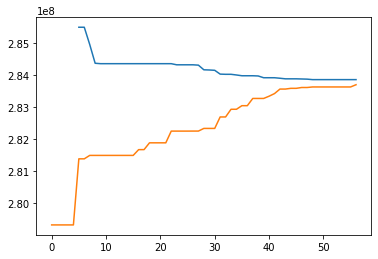

In [34]:
ax  = df["bestInteger"].plot()
ax1=df["cutsBestBound"].plot(ax=ax)
plt.savefig('plot.png', transparent=True)   
plt.show()

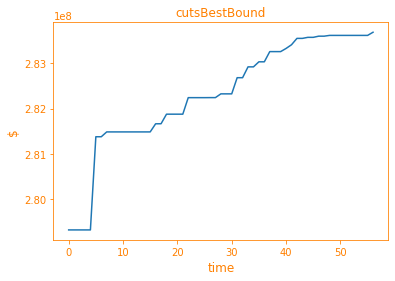

In [10]:
print_serie(df['cutsBestBound'],'cutsBestBound','$','time','logfile'+'Milp.png')

In [ ]:
import os
for filename in os.listdir("/content/"):
  if("log" in filename):
    df,dic =e.extract("/content/{}".format(filename))
    print(filename)
    print(df)